In [1]:
# import opencv, numpy
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# utility function for displaying multiple images
def ShowImgs(images, titles, row, column, size):
    fig = plt.figure(figsize = size)
    for i in range(len(images)):
        # cmap = 'gray' is ignored if image is 3D
        fig.add_subplot(row, column, i+1), plt.imshow(images[i], cmap = 'gray'), plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    plt.show()

### Part 2. Harris corner detector

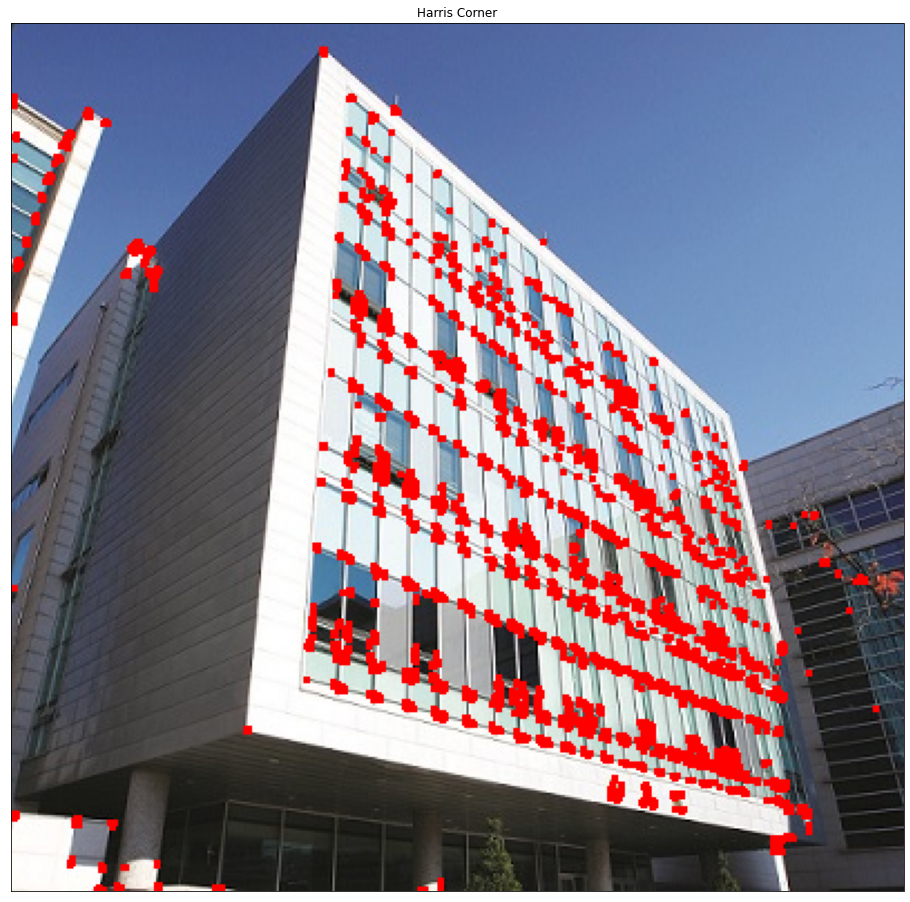

In [4]:
filename = 'building.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
# img, blockSize, ksize, k
dst = cv2.cornerHarris(gray,2,3,0.04)

dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[255,0,0]

ShowImgs([img], ["Harris Corner"], 1, 1, (16, 16))

### Part 1. Feature Matching

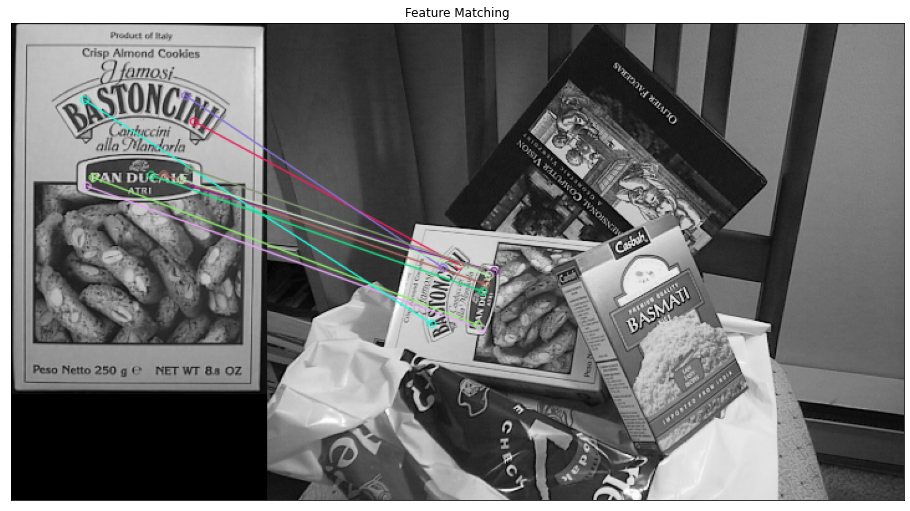

In [5]:
img1 = cv2.imread('box.png',cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.imread('box_in_scene.png',cv2.IMREAD_GRAYSCALE) # trainImage

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object (bruteforce search)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ShowImgs([img3], ["Feature Matching"], 1, 1, (16, 16))

### Part 2. Homography

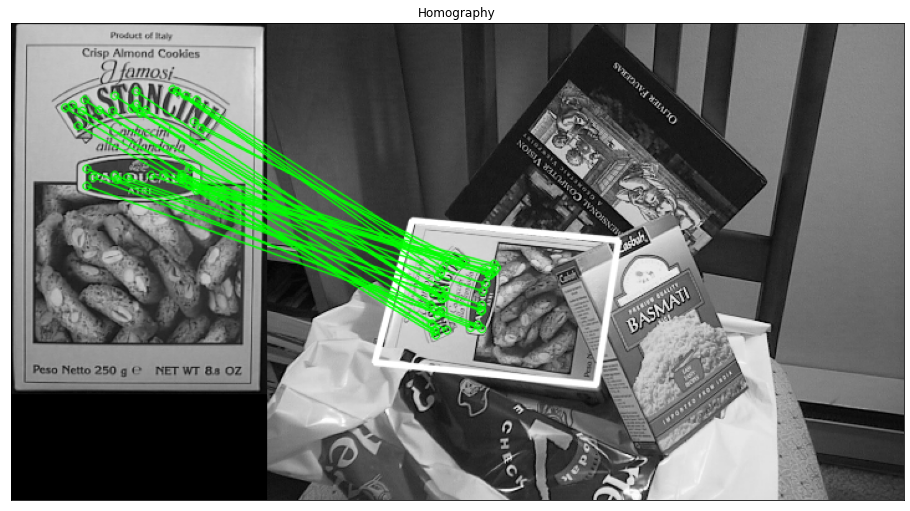

In [3]:
MIN_MATCH_COUNT = 10

img1 = cv2.imread('box.png',0)          # queryImage
img2 = cv2.imread('box_in_scene.png',0) # trainImage

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# store all the good matches as per Lowe's ratio test.
good = []
for m in matches:
    good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

ShowImgs([img3], ["Homography"], 1, 1, (16, 16))